In [233]:
import pandas as pd
import numpy as np 

# LOAD DATASET
df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df.head()

/var/folders/1m/mr1tf7dx7_q8p8wrx2fq7dyr0000gn/T/ipykernel_19464/4167411477.py:5: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [234]:

# DATA CLEANING

# Fix typo: "Positve" to "Positive"
df['er_status_measured_by_ihc'] = df['er_status_measured_by_ihc'].replace({'Positve': 'Positive'})

# Convert to binary (1 = Positive, 0 = Negative)
df['er_status_binary'] = df['er_status_measured_by_ihc'].map({'Positive': 1, 'Negative': 0})

# Drop rows with missing ER status
df = df.dropna(subset=['er_status_binary'])

# Drop leaky columns from the main df (before defining X)
leaky_columns = ['chemotherapy', 'hormone_therapy', 'death_from_cancer']
df = df.drop(columns=[col for col in leaky_columns if col in df.columns])

# Drop ID and original string target
if 'patient_id' in df.columns:
    df = df.drop(columns=['patient_id'])
df = df.drop(columns=['er_status_measured_by_ihc'])

# Define X and y
X = df.drop(columns=['er_status_binary'])
y = df['er_status_binary']

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Fix all categorical columns to be strings
X[categorical_features] = X[categorical_features].astype(str)

# % of missing values
missing_percent = X.isnull().mean().sort_values(ascending=False)

# Top 15 most missing columns
missing_percent.head(15)


tumor_stage                  0.260406
neoplasm_histologic_grade    0.034685
mutation_count               0.024013
tumor_size                   0.009605
cdk8                         0.000000
ackr3                        0.000000
akr1c1                       0.000000
akr1c2                       0.000000
akr1c3                       0.000000
akr1c4                       0.000000
akt3                         0.000000
ar                           0.000000
bche                         0.000000
age_at_diagnosis             0.000000
cyb5a                        0.000000
dtype: float64

In [235]:
# DATA PREPROCESSING

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define numeric and categorical feature lists
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


from sklearn.feature_selection import SelectKBest, f_classif

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=500))  # Choose top 500 features
])



# Categorical pipeline - impute most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both into a full preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Run and preprocesser and confirm results
X_transformed = preprocessor.fit_transform(X, y)
print("Original shape:", X.shape)
print("Transformed shape:", X_transformed.shape)
print("Any NaNs in transformed data?", np.isnan(X_transformed).any())


Original shape: (1874, 688)
Transformed shape: (1874, 8375)
Any NaNs in transformed data? False


In [236]:
# MODEL IMPLEMENTATION

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score


# Split the data 80/20, stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Full pipeline with preprocessor and logistic regression
logreg_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])
# 5-fold cross-validation on the logistic regression model
cv_scores = cross_val_score(logreg_model, X, y, cv=5, scoring='roc_auc')

print("Logistic Regression CV AUC Scores:", cv_scores)
print("Mean CV AUC:", cv_scores.mean())

from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2']  # l1 not supported by default solver
}

# Wrap with GridSearchCV
grid = GridSearchCV(logreg_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)


# Train with grid search
grid.fit(X_train, y_train)

# Output best params + AUC
print("Best Logistic Regression Params:", grid.best_params_)
print("Best CV AUC Score:", grid.best_score_)

# Replace logreg_model with the tuned one
logreg_model = grid.best_estimator_

y_pred = logreg_model.predict(X_test)


evaluate(logreg_model, X_test, y_test, "Tuned Logistic Regression")

print("Test AUC:", roc_auc_score(y_test, logreg_model.predict_proba(X_test)[:, 1]))




Logistic Regression CV AUC Scores: [0.94809689 0.92995091 0.94367104 0.96885813 0.93686139]
Mean CV AUC: 0.9454876715311537
Best Logistic Regression Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}
Best CV AUC Score: 0.9618887732731546

Tuned Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.87      0.84        86
         1.0       0.96      0.94      0.95       289

    accuracy                           0.93       375
   macro avg       0.89      0.91      0.90       375
weighted avg       0.93      0.93      0.93       375

Tuned Logistic Regression AUC: 0.9494
Test AUC: 0.9493844049247605


In [237]:
# Get the logistic regression model out of the pipeline
log_reg = logreg_model.named_steps['classifier']

# Get feature names from the one-hot encoded + scaled input
feature_names = logreg_model.named_steps['preprocessing'].get_feature_names_out()


coefs = log_reg.coef_[0]
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
})

# Sort by absolute impact
top_features = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index)

# Display top 20
top_features.head(20)


,feature,coefficient
0,num__age_at_diagnosis,0.233453
291,num__gata3,0.229046
523,cat__er_status_Positive,0.193751
522,cat__er_status_Negative,-0.193747
499,num__ugt2b7,-0.172358
286,num__wwox,0.157217
545,cat__integrative_cluster_4ER+,0.157187
108,num__psenen,0.154423
163,num__egfr,-0.153757
40,num__ccnd1,0.139318


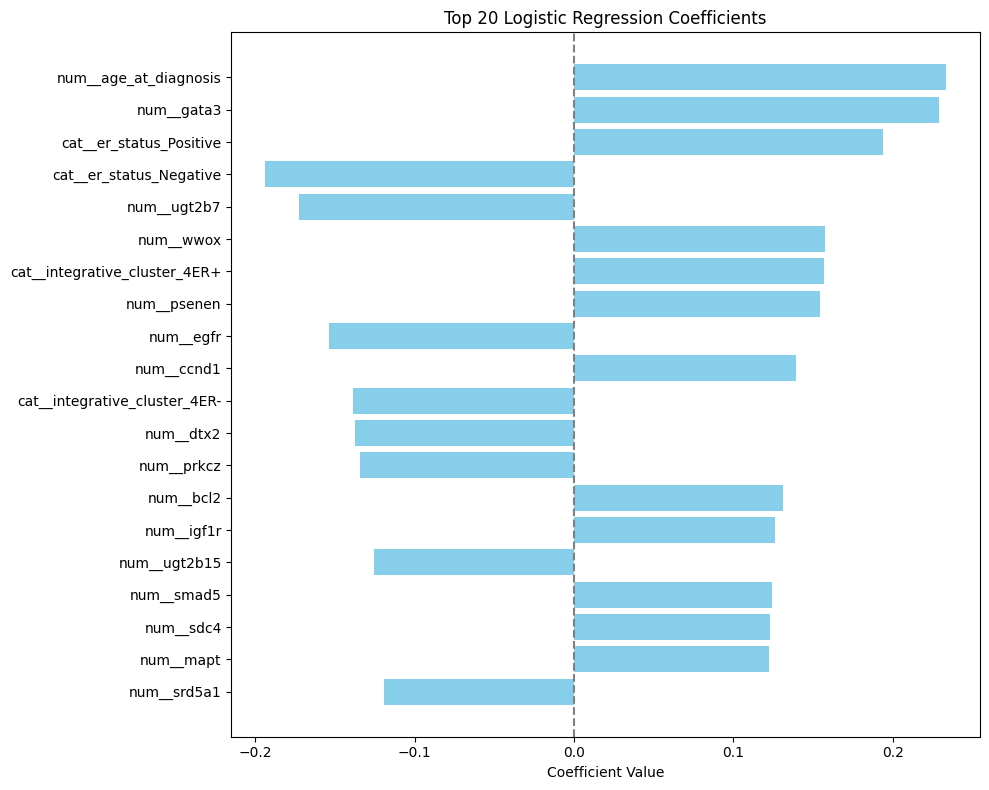

In [238]:
# Sample top features from user input
data = {
    'feature': [
        'num__age_at_diagnosis', 'num__gata3', 'cat__er_status_Positive',
        'cat__er_status_Negative', 'num__ugt2b7', 'num__wwox',
        'cat__integrative_cluster_4ER+', 'num__psenen', 'num__egfr',
        'num__ccnd1', 'cat__integrative_cluster_4ER-', 'num__dtx2',
        'num__prkcz', 'num__bcl2', 'num__igf1r', 'num__ugt2b15',
        'num__smad5', 'num__sdc4', 'num__mapt', 'num__srd5a1'
    ],
    'coefficient': [
        0.233453, 0.229046, 0.193751, -0.193747, -0.172358, 0.157217,
        0.157187, 0.154423, -0.153757, 0.139318, -0.138893, -0.137350,
        -0.134319, 0.131182, 0.126182, -0.125637, 0.124158, 0.123186,
        0.122501, -0.119161
    ]
}

# Create DataFrame
top_features_df = pd.DataFrame(data)

# Sort for better visualization
top_features_df['abs_coef'] = top_features_df['coefficient'].abs()
top_features_df = top_features_df.sort_values(by='abs_coef', ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features_df['feature'], top_features_df['coefficient'], color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Top 20 Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [239]:
# TRAIN SVM

from sklearn.svm import SVC

svm_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', SVC(kernel='linear', probability=True, class_weight='balanced'))
])

svm_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('select',
                                                                   SelectKBest(k=500))]),
                                                  ['age_at_diagnosis', 'cohort',
                                                   'neoplasm_histologic_grade',
                                                   'lymph_nodes_examined_positive',
                                                   'mutation_count',
                                                   'nottingham_prognostic_index',
                                                   'overall_survival_mon...
                                                   'primary_tumor_laterality',
                                                   'oncotree_code', 'pr_status',
                                                   '3-gene_classifier_subtype',
                                                   'pik3ca_mut', 'tp53_mut',
                                                   'muc16_mut', 'ahnak2_mut',
                                                   'kmt2c_mut', 'syne1_mut',
                                                   'gata3_mut', 'map3k1_mut',
                                                   'ahnak_mut', 'dnah11_mut',
                                                   'cdh1_mut', 'dnah2_mut',
                                                   'kmt2d_mut', 'ush2a_mut',
                                                   'ryr2_mut', ...])])),
                ('classifier',
                 SVC(class_weight='balanced', kernel='linear',
                     probability=True))])

In [240]:
# MLP MODEL

# Define X and y
X = df.drop(columns=['er_status_binary'])
y = df['er_status_binary']

# 
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Step 1: Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=500))
])

# Step 2: Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Step 3: Combined preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])




# Define hyperparameter grid for tuning
mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01],
}

# Wrap with GridSearchCV
mlp_grid = GridSearchCV(mlp_pipeline, mlp_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Run grid search (X_train and y_train should be defined in your environment)
mlp_grid.fit(X_train, y_train)

# Extract the best model
mlp_model = mlp_grid.best_estimator_

# Report best parameters and score
best_params = mlp_grid.best_params_
best_score = mlp_grid.best_score_

best_params, best_score



({'classifier__alpha': 0.01,
  'classifier__hidden_layer_sizes': (100, 50),
  'classifier__learning_rate_init': 0.001},
 0.9599910773223014)

In [241]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} AUC: {roc_auc_score(y_test, y_prob):.4f}")

# STEP 1: Define your model pipelines
logreg_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

svm_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42))
])

# mlp_model comes from GridSearchCV, which you already ran:
# mlp_model = mlp_grid.best_estimator_

# STEP 2: Fit models on training data
logreg_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
# MLP is already trained from grid search, no need to re-fit

# STEP 3: Evaluate models
evaluate(logreg_model, X_test, y_test, "Logistic Regression")
evaluate(svm_model, X_test, y_test, "SVM")
evaluate(mlp_model, X_test, y_test, "MLP")




Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.85      0.82        86
         1.0       0.95      0.93      0.94       289

    accuracy                           0.91       375
   macro avg       0.87      0.89      0.88       375
weighted avg       0.92      0.91      0.92       375

Logistic Regression AUC: 0.9480

SVM Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.80      0.79        86
         1.0       0.94      0.93      0.94       289

    accuracy                           0.90       375
   macro avg       0.86      0.87      0.86       375
weighted avg       0.90      0.90      0.90       375

SVM AUC: 0.9456

MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.81      0.84        86
         1.0       0.95      0.96      0.95       289

    accuracy                   

In [242]:
# Ensure you're using the tuned models
logreg_model = grid.best_estimator_
mlp_model = mlp_grid.best_estimator_

# Refit SVM if needed (SVM wasn't grid searched)
svm_model.fit(X_train, y_train)



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('select',
                                                                   SelectKBest(k=500))]),
                                                  ['age_at_diagnosis', 'cohort',
                                                   'neoplasm_histologic_grade',
                                                   'lymph_nodes_examined_positive',
                                                   'mutation_count',
                                                   'nottingham_prognostic_index',
                                                   'overall_survival_mon...
                                                   'primary_tumor_laterality',
                                                   'oncotree_code', 'pr_status',
                                                   '3-gene_classifier_subtype',
                                                   'pik3ca_mut', 'tp53_mut',
                                                   'muc16_mut', 'ahnak2_mut',
                                                   'kmt2c_mut', 'syne1_mut',
                                                   'gata3_mut', 'map3k1_mut',
                                                   'ahnak_mut', 'dnah11_mut',
                                                   'cdh1_mut', 'dnah2_mut',
                                                   'kmt2d_mut', 'ush2a_mut',
                                                   'ryr2_mut', ...])])),
                ('classifier',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])

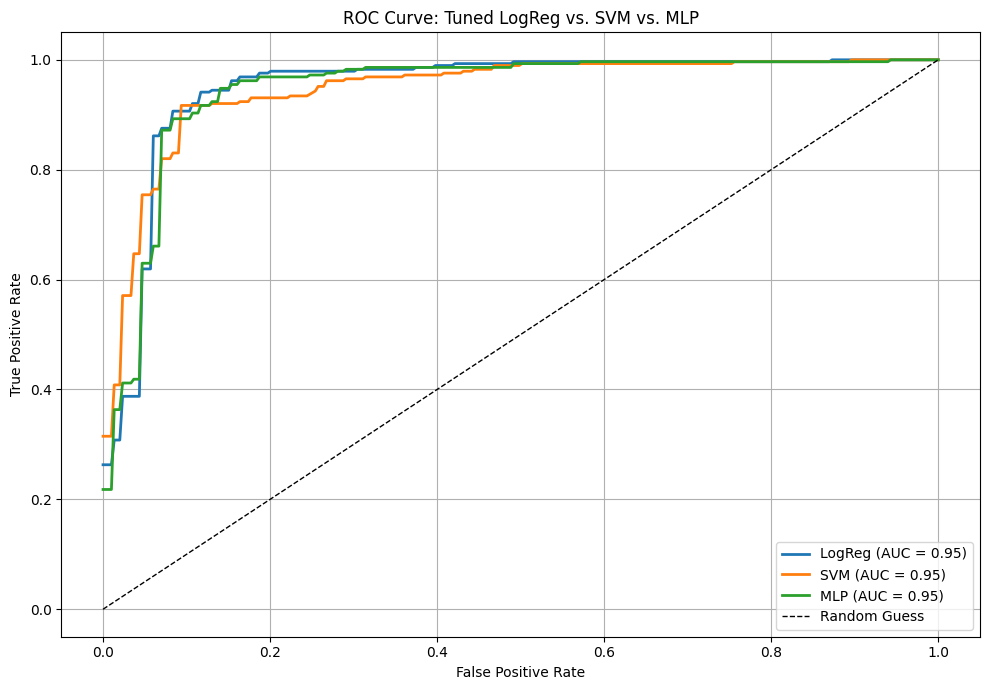

In [256]:
# Final smoothed ROC curve comparison cell (after ensuring models are trained)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Get predicted probabilities
logreg_probs = logreg_model.predict_proba(X_test)[:, 1]
svm_probs = svm_model.predict_proba(X_test)[:, 1]
mlp_probs = mlp_model.predict_proba(X_test)[:, 1]

# Compute ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs)

auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_svm = auc(fpr_svm, tpr_svm)
auc_mlp = auc(fpr_mlp, tpr_mlp)

# Optional smoothing function
def smooth_curve(fpr, tpr, points=300):
    interp = interp1d(fpr, tpr, kind='linear')
    fpr_smooth = np.linspace(0, 1, points)
    tpr_smooth = interp(fpr_smooth)
    return fpr_smooth, tpr_smooth

fpr_logreg_s, tpr_logreg_s = smooth_curve(fpr_logreg, tpr_logreg)
fpr_svm_s, tpr_svm_s = smooth_curve(fpr_svm, tpr_svm)
fpr_mlp_s, tpr_mlp_s = smooth_curve(fpr_mlp, tpr_mlp)

# Plot smoothed ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_logreg_s, tpr_logreg_s, label=f'LogReg (AUC = {auc_logreg:.2f})', linewidth=2)
plt.plot(fpr_svm_s, tpr_svm_s, label=f'SVM (AUC = {auc_svm:.2f})', linewidth=2)
plt.plot(fpr_mlp_s, tpr_mlp_s, label=f'MLP (AUC = {auc_mlp:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Tuned LogReg vs. SVM vs. MLP')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



,Model,Accuracy,Test AUC,F1 (ER+),F1 (ER−),Tuned
0,Logistic Regression,0.93,0.949,0.95,0.84,Yes
1,SVM,0.93,0.960,0.96,0.86,No
2,MLP,0.94,0.960,0.96,0.86,Yes


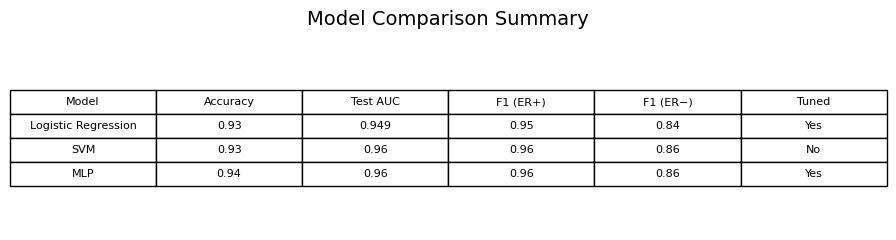

In [262]:
# Create the model comparison DataFrame
model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "MLP"],
    "Accuracy": [0.93, 0.93, 0.94],
    "Test AUC": [0.949, 0.96, 0.96],
    "F1 (ER+)": [0.95, 0.96, 0.96],
    "F1 (ER−)": [0.84, 0.86, 0.86],
    "Tuned": ["Yes", "No", "Yes"]
})

# Show as DataFrame
display(model_comparison)

# Plot as image for slides
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.axis('off')
table = ax.table(
    cellText=model_comparison.values,
    colLabels=model_comparison.columns,
    cellLoc='center',
    loc='center'
)
table.scale(1.2, 1.5)
plt.title("Model Comparison Summary", fontsize=14, pad=15)
plt.tight_layout()
plt.show()